In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import *

In [ ]:
from IPython.display import Audio
import torchaudio
from torchaudio.transforms import MelSpectrogram, MFCC, AmplitudeToDB
from scipy.signal import resample_poly

# Audio core

> Basic function to preprocess audio data before assembling it in a `DataBunch`.

In [ ]:
URLs.ESC50_SAMPLE = 'https://github.com/limeai/dataset/raw/master/esc50_sample.tgz'

In [ ]:
path = untar_data(URLs.ESC50_SAMPLE)
path.ls()

(#3) [/home/hiromi/.fastai/data/esc50_sample/dog,/home/hiromi/.fastai/data/esc50_sample/cat,/home/hiromi/.fastai/data/esc50_sample/meta.csv]

In [ ]:
t  = get_files(path, extensions='.wav', recurse=True)

In [ ]:
#export
audio_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get audio files in `path` recursively."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
test_eq(len(t), len(get_audio_files(path, recurse=True)))

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_audio_files` partial function that searches path suffix `suf` and passes along `kwargs`"
    def _inner(o, recurse=recurse, folders=folders): return get_audio_files(o/suf, recurse, folders)
    return _inner

In [ ]:
test_eq(len(get_files(path, extensions='.wav', recurse=True, folders='dog')),
        len(AudioGetter(                       recurse=True, folders='dog')(path)))

### Basic Types

In [ ]:
#export
def load_audio(fn, **kwargs):
    "Open and load an audio file"
    signal, sample_rate = torchaudio.load(fn)
    return signal, sample_rate

In [ ]:
#export
class AudioSignal(TupleBase):
    "Basic type for an audio signal"
    def show(self, ctx=None, **kwargs):
        return display(Audio(data=self.signal, rate=self.sample_rate))
    
    @classmethod
    def create(cls, fn:Path): return cls(load_audio(fn))
    
    signal,sample_rate = add_props(lambda i,self: self[i])
    
    @property
    def n_ch(self):
        "Number of channels"
        return self.signal.shape[0]

In [ ]:
audio = AudioSignal.create(get_audio_files(path, recurse=True)[0])

In [ ]:
audio.show()

In [ ]:
#export
class AudioSpectrogram(TensorImageBase): pass

#### MelSpectrogram

In [ ]:
@delegates(to=MelSpectrogram)
class MelSpectrogramify(Transform):
    def __init__(self, **kwargs):
        self.transformer = MelSpectrogram(**kwargs)
    def encodes(self, x:AudioSignal): return AudioSpectrogram(self.transformer(x.signal).detach())

In [ ]:
mel = MelSpectrogramify(sample_rate=audio.sample_rate, n_fft=2560)

In [ ]:
mel_spectrogram = mel(audio)

In [ ]:
mel_spectrogram.shape

torch.Size([1, 128, 173])

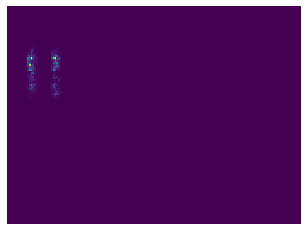

In [ ]:
mel_spectrogram.show()

In [ ]:
#export
@delegates(AmplitudeToDB)
class AmplitudeToDBify(Transform):
    def __init__(self, **kwargs):
        self.transformer = AmplitudeToDB(**kwargs)
    def encodes(self, x:AudioSpectrogram):
        return self.transformer(x)
    def encodes(self, x:AudioSignal):
        db_signal = self.transformer(x.signal)
        return AudioSignal(db_signal, x.sample_rate) # TODO HIROMI Do we really have to create a new one?

In [ ]:
amp = AmplitudeToDBify()

In [ ]:
mel_spectrogram_db = amp(mel_spectrogram)

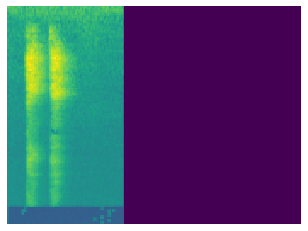

In [ ]:
mel_spectrogram_db.show()

Putting the two together

In [ ]:
mel_args = {'sample_rate': 44100, 'n_fft': 2560}

In [ ]:
audio_fn = get_audio_files(path, recurse=True)[5]

In [ ]:
pipe_audio = Pipeline([AudioSignal.create, MelSpectrogramify(**mel_args), AmplitudeToDBify()], as_item=True)
audio = pipe_audio(audio_fn)

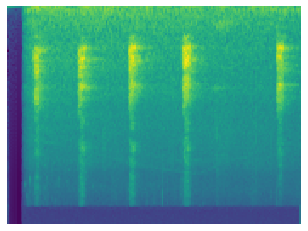

In [ ]:
pipe_audio.show(audio);

#### MFCC

In [ ]:
@delegates(to=MFCC)
class MFCCify(Transform):
    def __init__(self, **kwargs):
        print(kwargs)
        self.transformer = MFCC(**kwargs)
    def encodes(self, x:AudioSignal): return AudioSpectrogram(self.transformer(x.signal).detach())

In [ ]:
mfcc_args = {'sample_rate': 44100, 'melkwargs':{'n_fft': 2560}}

In [ ]:
pipe_audio = Pipeline([AudioSignal.create, MFCCify(**mfcc_args)], as_item=True)
audio = pipe_audio(audio_fn)

{'sample_rate': 44100, 'melkwargs': {'n_fft': 2560}}


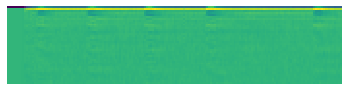

In [ ]:
audio.show()

### Preprocessing rules

#### Downmix / downsample

In [ ]:
URLs.multichannel = 'https://github.com/limeai/dataset/raw/master/multichannel/channel_placement.wav'
path_multi = download_data(URLs.multichannel, c_key=ConfigKey.Data)

In order to downmix audio into one channel (mono), all of the channels will be averaged together with `torch.mean`

In [ ]:
#export
def downmix(audio:AudioSignal)->AudioSignal: 
    "Downmix any stereo signals to mono."
    return AudioSignal(torch.mean(audio.signal.float(),0,keepdim=True),audio.sample_rate)

In [ ]:
audio_stereo = AudioSignal.create(path_multi)

In [ ]:
audio_stereo.show()

In [ ]:
test_eq(audio_stereo.n_ch,6)

In [ ]:
audio_mono = downmix(audio_stereo)

In [ ]:
test_eq(type(audio_stereo),type(audio_mono))
test_eq(audio_stereo.n_ch,6) #test that the nchannels of the initial signal is unchanged
test_eq(audio_mono.n_ch,1) #test that the nchannels of the new signal is 1

#### Resample
Resampling will be done using the [Polyfill Method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html#scipy.signal.resample_poly)

In [ ]:
#export
def Resample(new_sample_rate):
    '''Resample using faster polyphase technique and avoid FFT computation'''    
    def _inner(audio, new_sample_rate=new_sample_rate): 
        if audio.sample_rate == new_sample_rate: return audio
        return AudioSignal(resample_poly(audio.signal, new_sample_rate, audio.sample_rate, axis=-1),new_sample_rate)
    return _inner

In [ ]:
audio = AudioSignal.create(get_audio_files(path, recurse=True)[0])

In [ ]:
test_eq(audio.sample_rate,44100) #Initial sample rate is 44100 Hz

resampled_audio = Resample(80000)(audio) #Resample to 80000 Hz

test_eq(resampled_audio.sample_rate, 80000) # Check to make sure that sample_rate stuck
test_eq(type(audio),type(resampled_audio)) # Making sure that and AudioSignal goes in and also comes out

resampled_audio = Resample(8000)(audio) #Resample to 8000 Hz

test_eq(resampled_audio.sample_rate, 8000) # Check to make sure that sample_rate stuck

#### Pad/crop 

In [ ]:
#export
def resize(): pass # Kevin Pad or Crop to make sample size equal

#### Remove Silence

In [ ]:
URLs.whale = 'https://github.com/limeai/dataset/raw/master/whale/right_whale.wav'
path = download_data(URLs.whale, c_key=ConfigKey.Data)
audio = AudioSignal.create(path_whale)

In [ ]:
#export
from enum import auto, Enum
class RemoveType(Enum):
    TRIM, ALL, SPLIT = auto(),auto(),auto()

In [ ]:
signal = audio.signal
rate = audio.sample_rate
remove_type = RemoveType.ALL
threshold_db = 20           # The threshold (in decibels) below reference to consider as silence
pad_ms = 200                # The number of samples between analysis frames

In [ ]:
audio_stereo.signal.shape

torch.Size([6, 415135])

In [ ]:
signal.shape

torch.Size([1, 3869019])

In [ ]:
original = signal.clone()

In [ ]:
original.shape

torch.Size([1, 3869019])

In [ ]:
# how many samples are in 200 ms or 0.2 sec
pad_samples = int(pad_ms/1000*rate)

8820

In [ ]:
# if(pad > len(original)): return [original]

In [ ]:
from librosa.effects import split

In [ ]:
non_silent_interval = split(original.numpy(), top_db=threshold, hop_length=pad)

In [ ]:
non_silent_interval

In [ ]:
non_silent_interval[-1,-1]

In [ ]:
original[max(non_silent_interval[0, 0]-pad,0):min(non_silent_interval[-1, -1]+pad,len(original)-1)]

In [ ]:
original[max(splits[0, 0]-pad,0):min(splits[-1, -1]+pad,len(original)-1)].unsqueeze(0)]

In [ ]:
original

In [ ]:
# remove_type == "trim":
output = original[max(non_silent_interval[0, 0]-pad,0):min(non_silent_interval[-1, -1]+pad,len(original)-1)]

In [ ]:
def _merge_splits(splits, pad):
    clip_end = splits[-1][1]
    merged = []
    i=0
    while i < len(splits):
        start = splits[i][0]
        while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
            i += 1
        end = splits[i][1]
        merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
        i+=1
    return np.stack(merged)

In [ ]:
# if remove_type == "split":
#     output = [original[(max(a-pad,0)):(min(b+pad,len(original)))] for (a, b) in splits]
el
elif remove_type == "all":
    output = [torch.cat([original[a:b] for (a, b) in _merge_splits(splits, pad)])]
else: 
    raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not {remove_type}.")

In [ ]:
output

In [ ]:
#export
def remove_silence(signal, sample_rate, remove_type:RemoveType, threshold_db=20, pad_ms=200):
    '''Split signal at points of silence greater than 2*pad_ms '''
    actual = signal.clone().squeeze()
    pad = int(pad_ms/1000*rate)
    if(pad > len(actual)): return [actual]
    splits = split(actual.numpy(), top_db=threshold, hop_length=pad)
    if remove_type == RemoveType.TRIM:
        return [actual[(max(splits[0, 0]-pad,0)):splits[-1, -1]+pad].unsqueeze(0)]
    elif remove_type == RemoveType.ALL:
        return [torch.cat([actual[a:b] for (a, b) in _merge_splits(splits, pad)])]


In [ ]:
# test stuff

### Apply preprocessing rules

In [ ]:
#export
def apply_rules(items, rules): #TODO: Kevin Consolidate with 30_text_core apply_rules elsewhere
    "Returns a generator that apply `rules`  to `items`"
    return map(compose(*rules), items)

In [ ]:
rules = [downmix, Resample(8000)]

In [ ]:
for t in apply_rules([audio_stereo],rules):test_eq(t.sample_rate, 8000)

In [ ]:
t.show()

In [ ]:
#export
defaults.text_proc_rules = []
defaults.text_postproc_rules = []

In [ ]:
#export
class PreprocessBatch:
    "Apply `rules` and preprocess in parallel"
    def __init__(self, rules=None, post_rules=None, **tok_kwargs ):
        self.rules = L(ifnone(rules, defaults.audio_proc_rules))
        self.post_f = compose(*L(ifnone(post_rules, defaults.audio_postproc_rules)))

    def __call__(self, batch):
        for o in self.tok.pipe(apply_rules(batch, self.rules)): yield L(o).mapped(self.post_f)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)